# Data Access

Taken from a notebook created by Tyler Sutterly for the 2022 ICESat-2 Hackweek, put on by the e-science institute at UW.

In [1]:
import os
import geopandas as gpd
import ipyleaflet
import ipywidgets as widgets
import logging
#import panel as pn
#pn.extension()
import matplotlib.lines
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from shapely.geometry import Polygon
import warnings
# grimp and nisar functions
#import grimpfunc as grimp
#import nisardev as nisar
# sliderule functions
import sliderule.icesat2
import sliderule.io
import sliderule.ipysliderule
import pandas as pd
from datetime import datetime
# register progress bar and set workers
#ProgressBar().register()
#dask.config.set(num_workers=2)
# turn off warnings for demo
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

In [3]:
# set the url for the sliderule service
# set the logging level
sliderule.icesat2.init("icesat2sliderule.org", loglevel=logging.WARNING)

In [4]:
# display widgets for setting SlideRule parameters
SRwidgets = sliderule.ipysliderule.widgets()
# show widgets
widgets.VBox([
    SRwidgets.asset,
    SRwidgets.release,
    SRwidgets.surface_type,
    SRwidgets.length,
    SRwidgets.step,
    SRwidgets.confidence,
    SRwidgets.land_class,
    SRwidgets.iteration,
    SRwidgets.spread,
    SRwidgets.count,
    SRwidgets.window,
    SRwidgets.sigma
])

In [5]:
widgets.VBox([SRwidgets.projection, SRwidgets.layers])

In [6]:
polygon_gdf = gpd.read_file('./../data/UpperTuolRiverBasinOutline.geojson', crs='epsg:4326')
polygon_gdf.head()

,DN,geometry
0,0,"MULTIPOLYGON (((-119.79834 37.95837, -119.7980..."
1,1,"MULTIPOLYGON (((-119.58991 38.18616, -119.5888..."


<AxesSubplot:>

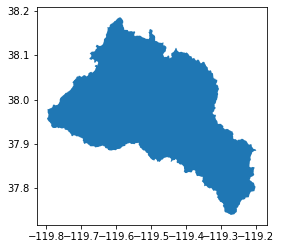

In [9]:
polygon_gdf.loc[[1],'geometry'].plot()

In [7]:
polygon_gdf = polygon_gdf[1:]

In [25]:
polygon_gdf.geometry

1    MULTIPOLYGON (((-119.58991 38.18616, -119.5888...
Name: geometry, dtype: geometry

In [8]:
gdf_exploded = polygon_gdf.explode()

In [10]:
gdf_exploded

,,DN,geometry
1,0,1,"POLYGON ((-119.58991 38.18616, -119.58888 38.1..."


In [9]:
# create ipyleaflet map in specified projection
m = sliderule.ipysliderule.leaflet(SRwidgets.projection.value)
m.add_layer(layers=SRwidgets.layers.value)

# Comment this section out if you want to draw your own polygon!
# ---
#box = shapely.geometry.Polygon([(-108.3,38.9), (-108.0,38.9), (-108.0,39.1), (-108.3, 39.1)])
#geobox = gpd.GeoDataFrame(geometry=[box], crs='EPSG:4326')
default_polygon = sliderule.io.from_geodataframe(gdf_exploded)
geodata = ipyleaflet.GeoData(geo_dataframe=gdf_exploded)
m.map.add_layer(geodata)
# ---

m.map

Map(center=[39, -108], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [10]:
#%%time
# sliderule asset and data release
asset = SRwidgets.asset.value
release = SRwidgets.release.value

# build sliderule parameters using latest values from widget
params = {
    # surface type: 0-land, 1-ocean, 2-sea ice, 3-land ice, 4-inland water
    "srt": SRwidgets.surface_type.index,
    # length of ATL06-SR segment in meters
    "len": SRwidgets.length.value,
    # step distance for successive ATL06-SR segments in meters
    "res": SRwidgets.step.value,
    # confidence level for PE selection
    "cnf": SRwidgets.confidence.value,
    # ATL08 land surface classifications
    "atl08_class": list(SRwidgets.land_class.value),
    # maximum iterations, not including initial least-squares-fit selection
    "maxi": SRwidgets.iteration.value,
    # minimum along track spread
    "ats": SRwidgets.spread.value,
    # minimum PE count
    "cnt": SRwidgets.count.value,
    # minimum height of PE window in meters
    "H_min_win": SRwidgets.window.value,
    # maximum robust dispersion in meters
    "sigma_r_max": SRwidgets.sigma.value
}

region = sliderule.icesat2.toregion(gdf_exploded)
params["poly"] = region["poly"]   # will always be the convex hull of the polygon
params["raster"] = region["raster"]   # raster will include all vertices, including holes. This is more processing, but is only an issue with very large requests.
gdf = sliderule.icesat2.atl06p(params, asset, version=release)

In [11]:
print(f'Returned {gdf.shape[0]} records')
gdf.head()

Returned 152603 records


,delta_time,w_surface_window_final,dh_fit_dx,spot,segment_id,pflags,h_mean,gt,rms_misfit,h_sigma,n_fit_photons,cycle,distance,dh_fit_dy,rgt,geometry
time,,,,,,,,,,,,,,,,
2018-10-15 23:22:20.018965444,2.488094e+07,3.0,-0.018228,4,210188,0,2501.377184,30,0.091912,0.033182,15,1,4.215353e+06,0.0,265,POINT (-119.62341 37.88878)
2018-10-15 23:22:20.021811344,2.488094e+07,3.0,-0.010939,4,210189,0,2501.116873,30,0.109110,0.028329,18,1,4.215373e+06,0.0,265,POINT (-119.62343 37.88896)
2018-10-15 23:22:20.027481712,2.488094e+07,3.0,-0.000515,4,210191,0,2501.053838,30,0.107823,0.032855,11,1,4.215413e+06,0.0,265,POINT (-119.62348 37.88932)
2018-10-15 23:22:20.030305900,2.488094e+07,3.0,0.008181,4,210192,0,2501.176924,30,0.156936,0.041974,14,1,4.215434e+06,0.0,265,POINT (-119.62350 37.88950)
2018-10-15 23:22:20.033126928,2.488094e+07,3.0,0.004802,4,210193,0,2501.271832,30,0.169124,0.045422,14,1,4.215454e+06,0.0,265,POINT (-119.62352 37.88968)


In [31]:
widgets.VBox([
    SRwidgets.variable,
    SRwidgets.cmap,
    SRwidgets.reverse,
])

In [32]:
m.GeoData(gdf, column_name=SRwidgets.variable.value, cmap='viridis',
    max_plot_points=10000, tooltip=True, colorbar=True)

In [36]:
gdf.sort_index(inplace=True)
gdf['acqdate'] = gdf.index.date
gdf['acqdate_string'] = gdf['acqdate'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

In [40]:
gdf.acqdate.unique()

array([datetime.date(2018, 10, 15), datetime.date(2018, 11, 13),
       datetime.date(2018, 12, 11), datetime.date(2019, 1, 9),
       datetime.date(2019, 2, 12), datetime.date(2019, 3, 12),
       datetime.date(2019, 4, 10), datetime.date(2019, 5, 14),
       datetime.date(2019, 6, 11), datetime.date(2019, 7, 9),
       datetime.date(2019, 7, 15), datetime.date(2019, 8, 7),
       datetime.date(2019, 8, 13), datetime.date(2019, 9, 9),
       datetime.date(2019, 10, 8), datetime.date(2019, 10, 14),
       datetime.date(2019, 11, 12), datetime.date(2019, 12, 9),
       datetime.date(2019, 12, 11), datetime.date(2020, 1, 7),
       datetime.date(2020, 1, 13), datetime.date(2020, 2, 5),
       datetime.date(2020, 2, 11), datetime.date(2020, 3, 9),
       datetime.date(2020, 3, 10), datetime.date(2020, 4, 7),
       datetime.date(2020, 4, 12), datetime.date(2020, 6, 8),
       datetime.date(2020, 7, 7), datetime.date(2020, 7, 12),
       datetime.date(2020, 8, 5), datetime.date(2020, 8, 10

In [33]:
gdf.to_file('./../data/tuolumne_all_06032022.geojson', driver='GeoJSON')

In [12]:
gdf.to_file('tuolumne_all_06032022.geojson', driver='GeoJSON')

In [13]:
gdf2 = gpd.read_file('tuolumne_all_06032022.geojson')

ERROR:fiona.ogrext:second must be in 0..59
Traceback (most recent call last):
  File "fiona/ogrext.pyx", line 275, in fiona.ogrext.FeatureBuilder.build
ValueError: second must be in 0..59


In [14]:
gdf2.head()

,time,delta_time,w_surface_window_final,dh_fit_dx,spot,segment_id,pflags,h_mean,gt,rms_misfit,h_sigma,n_fit_photons,cycle,distance,dh_fit_dy,rgt,geometry
0,2018-10-15T23:22:20.018999,2.488094e+07,3.0,-0.018228,4,210188,0,2501.377184,30,0.091912,0.033182,15,1,4.215353e+06,0.0,265,POINT (-119.62341 37.88878)
1,2018-10-15T23:22:20.021999,2.488094e+07,3.0,-0.010939,4,210189,0,2501.116873,30,0.109110,0.028329,18,1,4.215373e+06,0.0,265,POINT (-119.62343 37.88896)
2,2018-10-15T23:22:20.027000,2.488094e+07,3.0,-0.000515,4,210191,0,2501.053838,30,0.107823,0.032855,11,1,4.215413e+06,0.0,265,POINT (-119.62348 37.88932)
3,2018-10-15T23:22:20.030001,2.488094e+07,3.0,0.008181,4,210192,0,2501.176924,30,0.156936,0.041974,14,1,4.215434e+06,0.0,265,POINT (-119.62350 37.88950)
4,2018-10-15T23:22:20.033001,2.488094e+07,3.0,0.004802,4,210193,0,2501.271832,30,0.169124,0.045422,14,1,4.215454e+06,0.0,265,POINT (-119.62352 37.88968)


<AxesSubplot:>

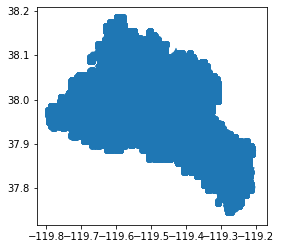

In [15]:
fig, ax = plt.subplots()
gdf.plot(ax=ax)
polygon_gdf.plot(ax=ax)